# Loan Default Prediction
## Team Members:
* Harish Puvvada
* Vamsi Mohan Ramineedi

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [2]:
df2012_13 = pd.read_csv(os.getenv('FDS')+'LoanStats_2012_to_2013.csv',low_memory=False,skiprows=1)
df2014 = pd.read_csv(os.getenv('FDS')+'LoanStats_2014.csv',low_memory=False,skiprows=1)

## Data Cleaning

In [3]:
dataset = pd.concat([df2012_13, df2014]) #merging 2007 to 2014 datasets
dataset = dataset.iloc[:,2:111]          #removing empty columns
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [4]:
Dataset_withBoolTarget['loan_status'].value_counts()
Dataset_withBoolTarget.shape

(376233, 82)

In [5]:
#print(Dataset_withBoolTarget.shape)
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
#print(x.isnull().sum()) #- to check how many null values in all the columns
print(dataset.shape)

(376233, 74)


In [6]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
dataset.shape

(376233, 52)

In [7]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print(Final_data.shape)

(376233, 18)


## Data Transformation


In [8]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:int(x))
Final_data.shape

(376233, 18)

In [9]:
#Final_data[Final_data['loan_status']==0]["last_pymnt_amnt"].value_counts()

## Filling Missing values and Feature scaling 


In [10]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
Final_data.shape

(376233, 18)

In [11]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1] 
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    310035
1     66198
Name: loan_status, dtype: int64

In [12]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=70000)
data_clean = pd.concat([loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
data_clean.shape

(136198, 18)

In [26]:
data_clean.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,0.103784,1.140751,-0.428499,0.899053,0.591081,-0.669264,0.551599,-0.323888,-0.949698,-0.263079,0.448250,-0.739288,0.403448,7.578434e-01,-0.495605,-2.887725e-01,-8.069507e-01,0
1,-0.847953,-0.230753,-0.058350,0.899053,1.362088,-0.709331,0.000000,-0.323888,-1.647187,-1.069638,0.000000,0.000000,0.000000,-5.667740e-14,0.000000,-1.169458e-16,3.209484e-16,0
2,-0.994375,0.043547,-0.637633,0.899053,0.591081,-0.565251,0.551599,1.571072,-0.990861,-0.061440,-0.584087,0.443643,2.869139,-5.076803e-01,-0.352235,3.741386e-01,-8.423907e-02,0
3,-0.872357,-0.230753,-0.650588,-2.167321,-0.179927,-0.708119,0.087642,3.466032,-0.037245,0.341840,-0.928200,-0.673570,-0.020880,1.214199e+00,-0.636993,-6.737509e-01,9.998283e-01,1
4,-1.287217,-0.505054,-0.613573,-0.634134,-0.179927,-0.731904,-0.840272,-0.323888,0.676253,3.164796,0.448250,-0.279259,-1.133308,-9.947153e-01,-0.327934,-8.292081e-01,4.613386e+00,1


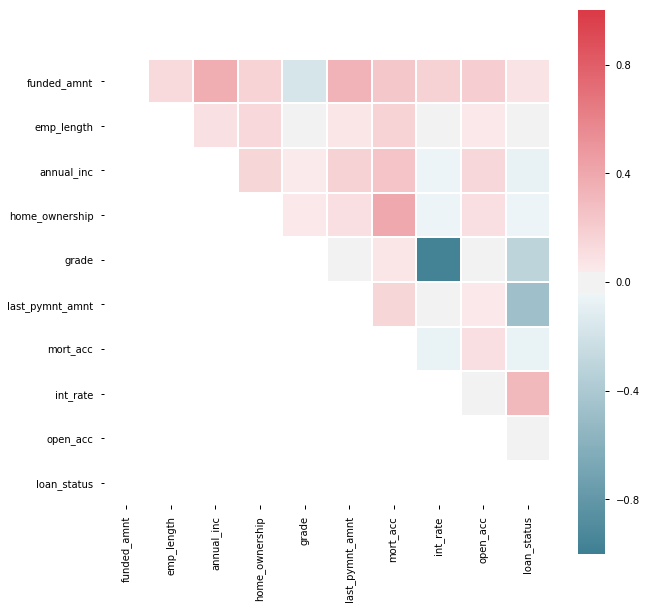

In [13]:
dataViz = data_clean[['funded_amnt','emp_length','annual_inc','home_ownership','grade','last_pymnt_amnt','mort_acc','int_rate','open_acc','loan_status']]

sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

### Bootstrapping 

These variables are created only for bootstrapping purpose.

In [23]:
bs_train, bs_test = train_test_split(data_clean, test_size = 0.33, random_state=42)

## Algorithms


## Random Forest


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.33, random_state=42)
randomForest = RandomForestClassifier(criterion = "gini")
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy,roc_score)

0.819917234014 0.819978871221


### Trying Confusion Matrix

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Text(0,0.5,'Normalized Gini Importance')

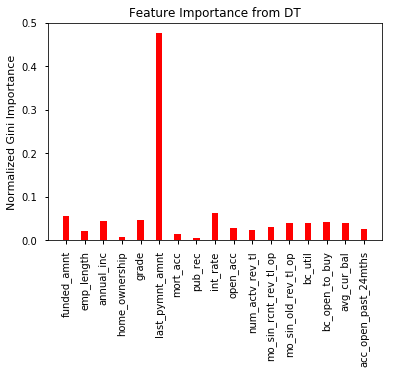

In [15]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(fields)), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

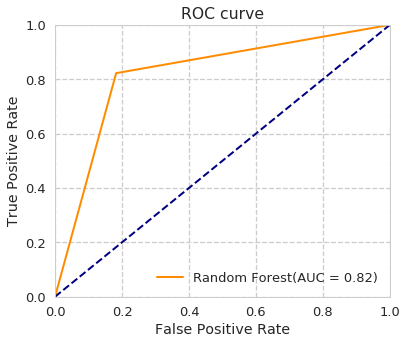

Average precision-recall score: 0.86


Text(0.5,1,'2-class Precision-Recall curve: AP=0.86')

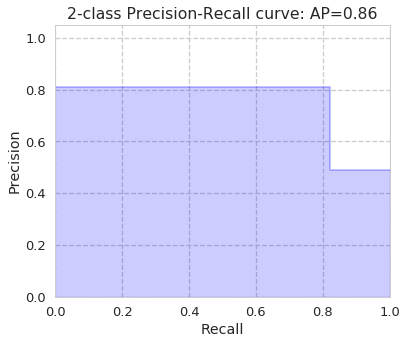

In [19]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")
plotAUC(y_test,rfPredict, 'Random Forest')
plt.show()

average_precision = average_precision_score(y_test, rfPredict)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, rfPredict)
plt.figure(figsize=(6,5))
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## Logistic Regression


0.827148133316


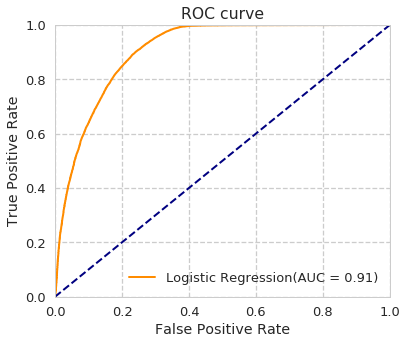

Average precision-recall score: 0.87


Text(0.5,1,'2-class Precision-Recall curve: AP=0.87')

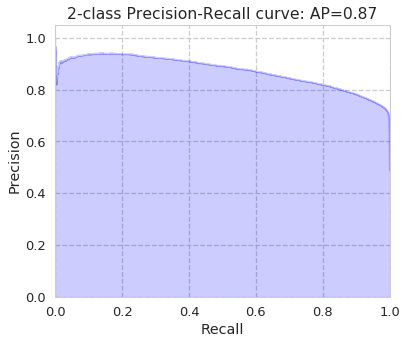

In [17]:
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print(LR_Accuracy)
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()

average_precision = average_precision_score(y_test, LR_Predict)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, LR_Predict)
plt.figure(figsize=(6,5))
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## Support Vector Machines(SVM)


In [20]:
clf_svm = svm.SVC(kernel = "rbf", degree = 3)
clf_svm.fit(X_train.iloc[:,[0,4,5,8]],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,[0,4,5,8]])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print(SVM_Accuracy)
#plotAUC(y_test,predictions_svm, 'SVM')
plt.show()

0.826658657055


In [29]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (lr == 1):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Linear regression fitting and predicting if lr==1
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        else:
            svm_i = svm.SVC(kernel='rbf', C = c) #hardcoding the value since it is negative power error.
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

In [30]:
#SampleSizes = [25, 50, 75, 100, 125, 136]*1000
SampleSizes = [25]*1000

LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, 1, 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n, 0, 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)

Text(0,0.5,'roc_auc_score')

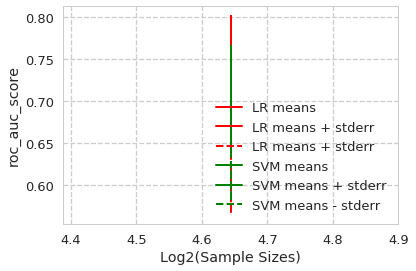

In [31]:
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-' , label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.legend(loc = 'lower right')
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')

## Cross Validation


In [34]:
# Bagged Decision Trees for Classification
#import pandas
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
#from sklearn.tree import DecisionTreeClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

KeyboardInterrupt: 

## Things to be done

In [19]:
Important...
### Apply SVM, KNN
### Neural Networks -  any one or two basic algo
### cross validation
### Bootstrapping
### precision,recall,F1score for all algorithms

More work...
### Different set of features 
### annual income,funded amount ----> create new var
### PCA
### Paramter tuning for all the algorithms
### Data Exploration -few more insights

Final Submission...
### report - Prob moti, target var and features defined, motivation for each model, eval approaches, assumption and limitations
### Final IPynb with clear comments, how to give data??
### Github Read me edit for your own sake

SyntaxError: invalid syntax (<ipython-input-19-ee33c4cb0211>, line 1)

## extra features - acc_now_delinq, pct_tl_nvr_dlq, num_sats, sub_grade
